In [1]:
## Imports all the packages.
import numpy as np
import pandas as pd
import os
import pdb
import array

from IPython.core.display import display, HTML
import scipy.stats as stats
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import auth
from google.cloud import bigquery
from google.colab import files

%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# get the amsterdamumcdb package from PyPI repository for use in Colab
!pip install amsterdamumcdb
import amsterdamumcdb as adb

###################SET PROJECT DEFAULTS##################
PROJECT_ID = "dynamic-reef-423509-d1" #@param {type:"string"}

# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_5_0' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = "dynamic-reef-423509-d1"

auth.authenticate_user()
print('Authenticated')

config_gbq = {'query':
          {'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset="amsterdamumcdb" + "." + "version1_5_0")
# sets default client settings by re-using the previously defined config
client = bigquery.Client(project=PROJECT_ID, location=LOCATION, default_query_job_config=def_config)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.6/528.6 kB 3.3 MB/s eta 0:00:00
Authenticated


In [2]:
#get Dictionary
dictionary = adb.get_dictionary()
dictionary = dictionary.convert_dtypes()
dictionary

concept_id                     concept_name    domain_id  \
0            8532                           FEMALE       Gender   
1            8507                             MALE       Gender   
2          581476                       Home Visit        Visit   
3          581383  Inpatient Cardiac Care Facility        Visit   
4            8870        Emergency Room - Hospital        Visit   
...           ...                              ...          ...   
10620    37079369              Supplemental result   Meas Value   
10621    36210399                    Not specified   Meas Value   
10622     4302933           Pleural fluid specimen     Specimen   
10623    45879739               No sample received   Meas Value   
10624     4104934        Incorrect sample received  Observation   

       concept_class_id         vocabulary_id concept_code  \
0                Gender                Gender            F   
1                Gender                Gender            M   
2                 Visit                 Visit  OMOP4822459   
3                 Visit  CMS Place of Service  OMOP4822038   
4                 Visit  CMS Place of Service           23   
...                 ...                   ...          ...   
10620            Answer                 LOINC    LA29938-0   
10621            Answer                 LOINC    LA27211-4   
10622          Specimen                SNOMED    418564007   
10623            Answer                 LOINC    LA12433-1   
10624  Clinical Finding                SNOMED    281267002   

       source_vocabulary_id                                source_code  \
0               AUMC Gender                                      Vrouw   
1               AUMC Gender                                        Man   
2               AUMC Origin                                       Huis   
3               AUMC Origin                   CCU/IC zelfde ziekenhuis   
4               AUMC Origin     Eerste Hulp afdeling zelfde ziekenhuis   
...                     ...                                        ...   
10620  AUMC Specimen Source                              11646-ZIE-OPM   
10621  AUMC Specimen Source                                    11646-0   
10622  AUMC Specimen Source                    11646-Vocht thoraxdrain   
10623  AUMC Specimen Source         11646-Niet afgenomen door afd/arts   
10624  AUMC Specimen Source  11646-Afname verkeerde buis door afd/arts   

                      source_code_description  source_frequency  \
0                                       Vrouw              7875   
1                                         Man             14735   
2                                        Huis                85   
3                    CCU/IC zelfde ziekenhuis               296   
4      Eerste Hulp afdeling zelfde ziekenhuis              2661   
...                                       ...               ...   
10620                                 ZIE-OPM               812   
10621                                       0                 1   
10622                       Vocht thoraxdrain                 1   
10623            Niet afgenomen door afd/arts                99   
10624     Afname verkeerde buis door afd/arts                 2   

       source_frequency_validated mapping_status equivalence  
0                            7875       APPROVED       EQUAL  
1                           14735       APPROVED       EQUAL  
2                              85       APPROVED       EQUAL  
3                             296       APPROVED       EQUAL  
4                            2661       APPROVED       EQUAL  
...                           ...            ...         ...  
10620                         812       APPROVED  EQUIVALENT  
10621                           1       APPROVED  EQUIVALENT  
10622                           1       APPROVED       EQUAL  
10623                          99       APPROVED  EQUIVALENT  
10624                           2       APPROVED  EQUIVALENT  

[10625

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#need to select all otherwise it errors out.

# path to base folder (right click on the directory: Datathon, and select 'Add to my Drive' in order to appear on My Drive)
drive_folder = '/content/drive/My Drive/Datathon/'


Mounted at /content/drive


In [4]:
#Shared functions
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=DATASET_PROJECT_ID,
      dialect='standard')


In [44]:
#ventilator associated complications
#https://lucid.app/lucidchart/6362a4b2-5049-443a-b9b1-699910665435/edit?viewport_loc=852%2C-124%2C1801%2C931%2C0_0&invitationId=inv_8e78c43f-7052-4032-804b-55150cac0457
#ventilated with 2 or more periods of stability and 2 or more periods of decompensation
def bol_VAC():
  isVentilated = 0
  #loop through measurement table to find UNIQUE visit_occurrence_id's with measurement_concept_id = 3004921
  sql = '''SELECT DISTINCT(visit_occurrence_id) FROM measurement WHERE NOT provider_id IS NULL AND measurement_concept_id IN (3004921) '''
  df_isVent = pd.read_gbq(sql, configuration=config_gbq, use_bqstorage_api=True)
  print(f'Number of Ventilation modes in visit_occurrances {df_isVent}')
  df_isVent.to_csv(drive_folder + "ventilated.csv", sep=',', index=False, encoding='utf-8')

bol_VAC()



Number of Ventilation modes in visit_occurrances        visit_occurrence_id
0                    20506
1                    20689
2                    22787
3                    18696
4                    19996
...                    ...
16471                 6650
16472                 8186
16473                 6653
16474                 7935
16475                13567

[16476 rows x 1 columns]


In [11]:
from dateutil import relativedelta
from datetime import datetime

#loop through visit_occurrances and select measurement_dates and check there are 3 concurrent
#loop ventilation by Occurance and return an Array tha is then checked for 3 concurrent days
def loopVentilationbyOccurrence(_dfrow):
  #3004921 for ventilation status
  _dfrow = str(_dfrow)

  sql = "SELECT DISTINCT visit_occurrence_id, measurement_date FROM measurement WHERE NOT provider_id IS NULL AND measurement_concept_id IN (3004921) AND visit_occurrence_id = " + _dfrow + " ORDER BY measurement_date"
  #df = pd.read_gbq(sql, dialect="standard")
  vent_df = pd.read_gbq(sql, configuration=config_gbq, use_bqstorage_api=True)
  print(f'Number of Ventilation days for visit_occurrance_id {str(_dfrow)} = {len(vent_df)}')

  #loop through vent_dataFrame and check for concurrent ventilated dates
  checkArray = checkConcurrentDates(vent_df)
  return checkArray

#new function that returns the df
#3004921 for ventilation status
def df_loopVentilationbyOccurrence(r_occid):
  r_occid = str(r_occid)
  sql = "SELECT DISTINCT visit_occurrence_id, measurement_date FROM measurement WHERE NOT provider_id IS NULL AND measurement_concept_id IN (3004921) AND visit_occurrence_id = " + r_occid + " ORDER BY measurement_date"
  vent_df = pd.read_gbq(sql, configuration=config_gbq, use_bqstorage_api=True)
  return vent_df


##6266	3024882	Oxygen/Total gas setting [Volume Fraction] Ventilator	Measurement	Clinical Observation	LOINC	19994-3	AUMC Numeric	6699	FiO2 %	91881
#Ventilator-associated condition (VAC), when the respiratory worsening fulfills some criteria for detecting hypoxemia defined as an :
#increase in daily minimum PEEP ≥ 3 cm H2O or FiO2  ≥ 0.20 sustained for at least 2 calendar days
# following a baseline period (2 calendar days) of stability or improvement.
def df_loopFi02byOccurrence(_df):
  #returns a DF with eg 88 records of same visit occurance (col1) with 88 days (col2)
  df_date =
  sql = "SELECT * FROM measurement WHERE NOT provider_id IS NULL AND measurement_concept_id IN (3024882) AND visit_occurrence_id = 20506 ORDER BY measurement_datetime"
  fi02check_df = pd.read_gbq(sql, configuration=config_gbq, use_bqstorage_api=True)
  return fi02check_df


#iterate through the dataFrame and append to an Array all those concurrent dates that the pt. is ventilated.
def checkConcurrentDates(_df):
  date1 =  _df.at[0, 'measurement_date']
  a_append = np.array(date1)
  #a = np.array([date1], dtype='datetime64[D]')

  for index, row in _df.iterrows():
    #compare dates - are they 1 day diff and mark when three concurrent
    if (index > 0): #start at 2nd date
      date1 =  _df.at[index-1, 'measurement_date']
      date2 = _df.at[index, 'measurement_date']
      difference = relativedelta.relativedelta(date2, date1)
      if (difference.days == 1):
        #print(difference.days)
        a_append = np.append(a_append, date2)
      #print(f"Date1 {date1} Date2: {date2} Diff: {difference.days} Array Size: {a_append.size}")
  return a_append


In [18]:
# get the amsterdamumcdb package from PyPI repository for use in Colab
#!pip install amsterdamumcdb
#import amsterdamumcdb as adb
#!pip install python-dateutil
############################### MAIN ########################

df_results = pd.read_csv(drive_folder + "ventilated.csv") # read the dataset to df_data
#loop through df_results - each occurance_id (that had a ventilation record) to then read measurements for Ventilation
df_merged = pd.DataFrame()

for index, row in df_results.iterrows():
  if (index < 1 ):
    r_occid = row['visit_occurrence_id']
    res_vent = df_loopVentilationbyOccurrence(r_occid) #returns a DF with eg 88 records of same visit occurance (col1) with 88 days (col2)
    #pass through dataFrame to find fi02 details for each day
    res_fi02 = df_loopFi02byOccurrence(res_vent)

    if (len(res_vent.index) >= 3): #ie > 3
      #df_merged = pd.concat([df_merged, res_vent], ignore_index=True, sort=False)

#dataFrame of occurrence_id's that have been ventilated for at least 3 days
#df_merged.to_csv(drive_folder + "a_3d.csv", sep=',', index=False, encoding='utf-8')




#Load the AmsterdamUMCdb dictionary.
Use the Filter button to quickly browse through the dictionary.

#Get Descendents of:
- Ventilator concepts 3004921 -- concept code for Ventilation
- Pneumonia = 255848 -- concept code for pneumonia
- 3005833 -- Gas panel - Blood

In [6]:
#3405	3004921	Ventilation mode Ventilator	Measurement	Clinical Observation	LOINC	20124-4	AUMC List	12290	Ventilatie Mode (Set)	15614454
##check for descendants of ventilation mode
descendantsV = pd.read_gbq(
    '''
    SELECT descendant_concept_id
    FROM concept_ancestor
    WHERE ancestor_concept_id = 3004921 -- concept code for Ventilation
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

#36308445 - use this for Meas value domain

# filter dictionary on all descendants
dictionary[dictionary['concept_id'].isin(descendantsV['descendant_concept_id'])]

concept_id                 concept_name    domain_id  \
3358     3004921  Ventilation mode Ventilator  Measurement   
3370     3004921  Ventilation mode Ventilator  Measurement   
3405     3004921  Ventilation mode Ventilator  Measurement   
3406     3004921  Ventilation mode Ventilator  Measurement   
3407     3004921  Ventilation mode Ventilator  Measurement   
3567     3004921  Ventilation mode Ventilator  Measurement   

          concept_class_id vocabulary_id concept_code source_vocabulary_id  \
3358  Clinical Observation         LOINC      20124-4            AUMC List   
3370  Clinical Observation         LOINC      20124-4            AUMC List   
3405  Clinical Observation         LOINC      20124-4            AUMC List   
3406  Clinical Observation         LOINC      20124-4            AUMC List   
3407  Clinical Observation         LOINC      20124-4            AUMC List   
3567  Clinical Observation         LOINC      20124-4            AUMC List   

     source_code    source_code_description  source_frequency  \
3358        9534     Type beademing Evita 1             42108   
3370        9652  Type Beademing Evita 4(2)                 1   
3405       12290      Ventilatie Mode (Set)          15614454   
3406       12347  Ventilatie Mode (Set) (2)                85   
3407       12376        Mode (Bipap Vision)               244   
3567        6685     Type Beademing Evita 4             44609   

      source_frequency_validated mapping_status equivalence  
3358                       36981       APPROVED       EQUAL  
3370                           1       APPROVED       EQUAL  
3405                     1283485       APPROVED       EQUAL  
3406                          85       APPROVED       EQUAL  
3407                         244       APPROVED       EQUAL  
3567                       40921       APPROVED       EQUAL

In [28]:
#255848 concept code for Pneumonia
descendantsP = pd.read_gbq(
    '''
    SELECT descendant_concept_id
    FROM concept_ancestor
    WHERE ancestor_concept_id = 255848 -- concept code for pneumonia
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

# filter dictionary on all descendants
dictionary[dictionary['concept_id'].isin(descendantsP['descendant_concept_id'])]


concept_id              concept_name  domain_id concept_class_id  \
7798      4309106      Aspiration pneumonia  Condition         Disorder   
7827       257315       Bacterial pneumonia  Condition         Disorder   
7846      4049965          Fungal pneumonia  Condition         Disorder   
7878       255848                 Pneumonia  Condition         Disorder   
7906       261326           Viral pneumonia  Condition         Disorder   
8004       261326           Viral pneumonia  Condition         Disorder   
8567      4309106      Aspiration pneumonia  Condition         Disorder   
8624      4309106      Aspiration pneumonia  Condition         Disorder   
8649       257315       Bacterial pneumonia  Condition         Disorder   
8665      4049965          Fungal pneumonia  Condition         Disorder   
8678       255848                 Pneumonia  Condition         Disorder   
8692       257315       Bacterial pneumonia  Condition         Disorder   
8709      4190647  Pneumocystosis pneumonia  Condition         Disorder   
8729       261326           Viral pneumonia  Condition         Disorder   
8758       257315       Bacterial pneumonia  Condition         Disorder   
8970      4049965          Fungal pneumonia  Condition         Disorder   
9137       255848                 Pneumonia  Condition         Disorder   
9232       255848                 Pneumonia  Condition         Disorder   
9234      4309106      Aspiration pneumonia  Condition         Disorder   
9239       261326           Viral pneumonia  Condition         Disorder   
9372       255848                 Pneumonia  Condition         Disorder   
10040      255848                 Pneumonia  Condition         Disorder   
10058      255848                 Pneumonia  Condition         Disorder   
10110      255848                 Pneumonia  Condition         Disorder   
10174      255848                 Pneumonia  Condition         Disorder   
10260     4049965          Fungal pneumonia  Condition         Disorder   
10364     4190647  Pneumocystosis pneumonia  Condition         Disorder   

      vocabulary_id concept_code source_vocabulary_id source_code  \
7798         SNOMED    422588002       AUMC Diagnosis   18673-614   
7827         SNOMED     53084003       AUMC Diagnosis   18673-615   
7846         SNOMED    233613009       AUMC Diagnosis   18673-616   
7878         SNOMED    233604007       AUMC Diagnosis   18673-617   
7906         SNOMED     75570004       AUMC Diagnosis   18673-619   
8004         SNOMED     75570004       AUMC Diagnosis    17026-49   
8567         SNOMED    422588002       AUMC Diagnosis    17026-44   
8624         SNOMED    422588002       AUMC Diagnosis   18671-162   
8649         SNOMED     53084003       AUMC Diagnosis   18671-163   
8665         SNOMED    233613009       AUMC Diagnosis   18671-164   
8678         SNOMED    233604007       AUMC Diagnosis   18671-165   
8692         SNOMED     53084003       AUMC Diagnosis    17005-18   
8709         SNOMED    415125002       AUMC Diagnosis   18671-166   
8729         SNOMED     75570004       AUMC Diagnosis   18671-167   
8758         SNOMED     53084003       AUMC Diagnosis    17026-45   
8970         SNOMED    233613009       AUMC Diagnosis    17026-46   
9137         SNOMED    233604007       AUMC Diagnosis    17026-47   
9232         SNOMED    233604007       AUMC Diagnosis    17019-84   
9234         SNOMED    422588002       AUMC Diagnosis    17005-17   
9239         SNOMED     75570004       AUMC Diagnosis    17005-22   
9372         SNOMED    233604007       AUMC Diagnosis    16658-12   
10040        SNOMED    233604007       AUMC Diagnosis    17005-20   
10058        SNOMED    233604007       AUMC Diagnosis   17029-116   
10110        SNOMED    233604007       AUMC Diagnosis    16998-38   
10174        SNOMED    233604007       AUMC Diagnosis     13134-1   
10260        SNOMED    233613009       AUMC Diagnosis    17005-19   
10364        SNOMED    415125002       AUMC

In [29]:
descendants = pd.read_gbq(
    '''
    SELECT descendant_concept_id
    FROM concept_ancestor
    WHERE ancestor_concept_id = 3005833 -- Gas panel - Blood
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

# filter dictionary on all descendants
dictionary[dictionary['concept_id'].isin(descendants['descendant_concept_id'])]


concept_id                                concept_name    domain_id  \
5060     3013290  Carbon dioxide [Partial pressure] in Blood  Measurement   
5066     3006576         Bicarbonate [Moles/volume] in Blood  Measurement   
5080     3012501         Base excess in Blood by calculation  Measurement   
5093     3027315          Oxygen [Partial pressure] in Blood  Measurement   
5203     3010421                                 pH of Blood  Measurement   
5277     3005629                    Inhaled oxygen flow rate  Measurement   
5340     3013290  Carbon dioxide [Partial pressure] in Blood  Measurement   
5349     3027315          Oxygen [Partial pressure] in Blood  Measurement   
5354     3027315          Oxygen [Partial pressure] in Blood  Measurement   
5409     3005629                    Inhaled oxygen flow rate  Measurement   
5418     3006576         Bicarbonate [Moles/volume] in Blood  Measurement   
5514     3013290  Carbon dioxide [Partial pressure] in Blood  Measurement   
5516     3010421                                 pH of Blood  Measurement   
5550     3012501         Base excess in Blood by calculation  Measurement   
5971     3020716                Inhaled oxygen concentration  Measurement   
6105     3020716                Inhaled oxygen concentration  Measurement   

          concept_class_id vocabulary_id concept_code source_vocabulary_id  \
5060              Lab Test         LOINC      11557-6      AUMC Laboratory   
5066              Lab Test         LOINC       1959-6      AUMC Laboratory   
5080              Lab Test         LOINC      11555-0      AUMC Laboratory   
5093              Lab Test         LOINC      11556-8      AUMC Laboratory   
5203              Lab Test         LOINC      11558-4      AUMC Laboratory   
5277  Clinical Observation         LOINC       3151-8      AUMC Laboratory   
5340              Lab Test         LOINC      11557-6      AUMC Laboratory   
5349              Lab Test         LOINC      11556-8      AUMC Laboratory   
5354              Lab Test         LOINC      11556-8      AUMC Laboratory   
5409  Clinical Observation         LOINC       3151-8      AUMC Laboratory   
5418              Lab Test         LOINC       1959-6      AUMC Laboratory   
5514              Lab Test         LOINC      11557-6      AUMC Laboratory   
5516              Lab Test         LOINC      11558-4      AUMC Laboratory   
5550              Lab Test         LOINC      11555-0      AUMC Laboratory   
5971  Clinical Observation         LOINC       3150-0         AUMC Numeric   
6105  Clinical Observation         LOINC       3150-0         AUMC Numeric   

     source_code      source_code_description  source_frequency  \
5060        9990                 pCO2 (bloed)            659807   
5066        9992             Act.HCO3 (bloed)            657442   
5080        9994                 B.E. (bloed)            654665   
5093        9996                  PO2 (bloed)            654417   
5203       12310                   pH (bloed)            659777   
5277       10387  Zuurstof toediening (bloed)              8229   
5340       21213           PCO2 (bloed) - kPa              9464   
5349       21214            PO2 (bloed) - kPa              9392   
5354        7433                          PO2             25372   
5409       18587          Zuurstof toediening                99   
5418        6810                         HCO3             25251   
5514        6846                         PCO2             25348   
5516        6848                           PH             25371   
5550        6807                         B.E.             25210   
5971        8869                    O2 Volume             85386   
6105        9664                 O2 Volume(2)                 5   

      source_frequency_validated mapping_status equivalence  
5060                      659807       APPROVED       EQUAL  
5066                      657442       APPROVED       EQUAL  
5080                      654665       APPR

A blood gas isn't really a single result or measurement (https://en.wikipedia.org/wiki/Arterial_blood_gas_test), so you need to search for the actual components, such as:
3010421 | pH of Blood
3013290 | Carbon dioxide [Partial pressure] in Blood
3027315 | Oxygen [Partial pressure] in Blood
If you need to filter on arterial or venous samples, you would need to combine your selection with the specimen table. For example, specimen_concept_id 4047496 means Arterial blood specimen.

In [ ]:
#Need to check that this occurs after ventilation
def isVentCriterea(visit_occ_id):
  #use pneuPD and update select statement based on
  sql = '''

    '''
  df = pd.read_gbq(sql, configuration=config_gbq, use_bqstorage_api=True)
  #df = pd.DataFrame(data)
  print(f'is Ventilated...: {len(df)}')
  return df

In [67]:
###GET MEASUREMENT FIELDS
cO2PP_PD = pd.read_gbq(
    '''
    SELECT
      visit_occurrence_id, count(visit_occurrence_id) as visit_occurrence_CO2_count
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3035357 --Carbon dioxide [Partial pressure] in Exhaled gas
    )
    group by visit_occurrence_id
    order by visit_occurrence_CO2_count DESC
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

print(f'Number of Partial pressure of CO2 values: {len(cO2PP_PD)}')
cO2PP_PD

Number of Partial pressure of CO2 values: 12606


visit_occurrence_id  visit_occurrence_CO2_count
0                    11572                        3225
1                     9220                        1556
2                    22324                        1420
3                    20341                        1112
4                    11413                        1110
...                    ...                         ...
12601                20785                           1
12602                17404                           1
12603                23225                           1
12604                10904                           1
12605                11365                           1

[12606 rows x 2 columns]

In [68]:
#need to loop through this SELECT STATEMENT - could include array of values for visit_occurance_id
pneuPD = pd.read_gbq(
    '''
    SELECT  visit_occurrence_id, count(visit_occurrence_id) as visit_occurrence_Pneumonia_count
    FROM condition_occurrence
    WHERE
       condition_concept_id IN (
        255848  --Pneumonia
    )
    group by visit_occurrence_id
    order by visit_occurrence_Pneumonia_count DESC
    #AND visit_occurrence_id = 22324	##need to loop through all the visit_occurances that we have End Tidal for to find pneumonias
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

print(f'Values of Pneumonia for visit_occurance ...: {len(pneuPD)}')
pneuPD

Values of Pneumonia for visit_occurance ...: 516


visit_occurrence_id  visit_occurrence_Pneumonia_count
0                   4564                               124
1                   4314                                85
2                  18523                                76
3                  22127                                67
4                   1619                                57
..                   ...                               ...
511                13267                                 1
512                18138                                 1
513                 2019                                 1
514                16873                                 1
515                19189                                 1

[516 rows x 2 columns]

In [69]:
#now bring back all those visit_occurrences with Vent + Pneumonia
#AND c.visit_occurrence_id = 4314	##need to loop through all the visit_occurances that we have End Tidal for to find pneumonias

joinPD = pd.read_gbq(
    '''
    SELECT c.visit_occurrence_id, count(c.visit_occurrence_id) as visit_occurrence_count
    FROM condition_occurrence c
    INNER JOIN measurement m ON m.visit_occurrence_id = c.visit_occurrence_id
    WHERE
      NOT m.provider_id IS NULL -- ignore unvalidated device data
      AND c.condition_concept_id IN (
        255848  --Pneumonia
      )
    group by c.visit_occurrence_id
    order by visit_occurrence_count DESC
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

print(f'Values of Pneumonia for visit_occurance ...: {len(joinPD)}')
joinPD


Values of Pneumonia for visit_occurance ...: 516


visit_occurrence_id  visit_occurrence_count
0                   4314                 3356735
1                   4564                 3145880
2                  22127                 3136873
3                  18523                 2696936
4                   7885                 2406888
..                   ...                     ...
511                 7888                     167
512                15374                     156
513                23304                     155
514                 4476                     130
515                   99                      99

[516 rows x 2 columns]

#USING THE VISIT_OCCURRANCE_ID
using the visit_occurrance_id specifically of a visit_occurance with a high count of CO2 partial pressure values recorded - we can construct a graph

In [73]:
cO2PP = pd.read_gbq(
    '''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3035357 --Carbon dioxide [Partial pressure] in Exhaled gas
    )
    AND visit_occurrence_id = 4564 ##ie for a particular Person/Occurance at hospital
    LIMIT 2000
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

print(f'Number of Partial pressure of CO2 values: {len(cO2PP)}')
#Measurement_concept - 3004921 -- 3004921	Ventilation mode Ventilator	Measurement	Clinical Observation	LOINC

cO2PP

Number of Partial pressure of CO2 values: 318


person_id  visit_occurrence_id  measurement_concept_id  \
0         3962                 4564                 3035357   
1         3962                 4564                 3035357   
2         3962                 4564                 3035357   
3         3962                 4564                 3035357   
4         3962                 4564                 3035357   
..         ...                  ...                     ...   
313       3962                 4564                 3035357   
314       3962                 4564                 3035357   
315       3962                 4564                 3035357   
316       3962                 4564                 3035357   
317       3962                 4564                 3035357   

         measurement_datetime  measurement_type_concept_id  \
0   2013-02-03 12:48:00+00:00                        32817   
1   2013-02-03 15:34:00+00:00                        32817   
2   2013-02-06 02:34:00+00:00                        32817   
3   2013-02-03 13:34:00+00:00                        32817   
4   2013-02-08 01:34:00+00:00                        32817   
..                        ...                          ...   
313 2013-01-10 11:34:00+00:00                        32817   
314 2013-01-10 13:34:00+00:00                        32817   
315 2013-01-10 01:34:00+00:00                        32817   
316 2013-01-10 00:34:00+00:00                        32817   
317 2013-01-10 12:34:00+00:00                        32817   

                               value_as_number  unit_concept_id  provider_id  
0     2.00000000000000000000000000000000000000             8876           40  
1     5.00000000000000000000000000000000000000             8876           40  
2     6.00000000000000000000000000000000000000             8876           40  
3     9.00000000000000000000000000000000000000             8876           40  
4    10.00000000000000000000000000000000000000             8876           40  
..                                         ...              ...          ...  
313  31.00000000000000000000000000000000000000             8876           40  
314  31.00000000000000000000000000000000000000             8876           40  
315  32.00000000000000000000000000000000000000             8876           40  
316  32.00000000000000000000000000000000000000             8876           40  
317  32.00000000000000000000000000000000000000             8876           40  

[318 rows x 8 columns]

In [74]:
ventPP = pd.read_gbq(
    '''
    SELECT
    *
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3004921 --Ventilation mode Ventilator	Measurement
    )
    AND visit_occurrence_id = 4564 #ie for a particular Person/Occurance at hospital
    #AND value_as_number IS NOT NULL
    ORDER BY measurement_datetime
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

print(f'Number of Ventilation measurements: {len(cO2PP)}')
#Measurement_concept - 3004921 -- 3004921	Ventilation mode Ventilator	Measurement	Clinical Observation	LOINC

ventPP


Number of Ventilation measurements: 318


measurement_id  person_id  measurement_concept_id measurement_date  \
0          18637141       3962                 3004921       2013-01-01   
1          18637263       3962                 3004921       2013-01-01   
2          18637444       3962                 3004921       2013-01-01   
3          18637509       3962                 3004921       2013-01-01   
4          18637594       3962                 3004921       2013-01-01   
..              ...        ...                     ...              ...   
319        18662437       3962                 3004921       2013-02-08   
320        18662506       3962                 3004921       2013-02-08   
321        18662574       3962                 3004921       2013-02-08   
322        18662642       3962                 3004921       2013-02-08   
323        18662708       3962                 3004921       2013-02-08   

         measurement_datetime measurement_time  measurement_type_concept_id  \
0   2013-01-01 00:34:00+00:00         00:34:00                        32817   
1   2013-01-01 01:34:00+00:00         01:34:00                        32817   
2   2013-01-01 03:34:00+00:00         03:34:00                        32817   
3   2013-01-01 04:34:00+00:00         04:34:00                        32817   
4   2013-01-01 05:34:00+00:00         05:34:00                        32817   
..                        ...              ...                          ...   
319 2013-02-08 04:34:00+00:00         04:34:00                        32817   
320 2013-02-08 05:34:00+00:00         05:34:00                        32817   
321 2013-02-08 06:34:00+00:00         06:34:00                        32817   
322 2013-02-08 07:34:00+00:00         07:34:00                        32817   
323 2013-02-08 08:34:00+00:00         08:34:00                        32817   

     operator_concept_id value_as_number  value_as_concept_id  ...  \
0                   <NA>            None             45880365  ...   
1                   <NA>            None             45880365  ...   
2                   <NA>            None             36308445  ...   
3                   <NA>            None             36308445  ...   
4                   <NA>            None             36308445  ...   
..                   ...             ...                  ...  ...   
319                 <NA>            None             45880365  ...   
320                 <NA>            None             45880365  ...   
321                 <NA>            None             45880365  ...   
322                 <NA>            None             45880365  ...   
323                 <NA>            None             45880365  ...   

     provider_id visit_occurrence_id visit_detail_id  \
0             40                4564            <NA>   
1             40                4564            <NA>   
2             40                4564            <NA>   
3             40                4564            <NA>   
4             40                4564            <NA>   
..           ...                 ...             ...   
319           40                4564            <NA>   
320           40                4564            <NA>   
321           40                4564            <NA>   
322           40                4564            <NA>   
323           40                4564            <NA>   

     measurement_source_value  measurement_source_concept_id  \
0       Ventilatie Mode (Set)                           <NA>   
1       Ventilatie Mode (Set)                           <NA>   
2       Ventilatie Mode (Set)                           <NA>   
3       Ventilatie Mode (Set)                           <NA>   
4       Ventilatie Mode (Set)                           <NA>   
..                        ...                            ...   
319     Ventilatie Mode (Set)                           <NA>   
320     Ventilatie Mode (Set)                           <NA>   
321     Ventilatie Mode (Set)                           <NA>   
3

In [63]:
#Need to check that this occurs after ventilation
def checkPneumonia(visit_occ_id):
  #use pneuPD and update select statement based on
  sql = '''SELECT DISTINCT  person_id, condition_start_datetime, condition_end_datetime , visit_occurrence_id, condition_source_value FROM condition_occurrence
    WHERE
      condition_concept_id IN (
        255848  --Pneumonia
      )
    AND visit_occurrence_id = ''' + str(visit_occ_id) + '''
    #ORDER BY measurement_datetime
    '''
  df = pd.read_gbq(sql, configuration=config_gbq, use_bqstorage_api=True)
  #df = pd.DataFrame(data)
  print(f'Values of Pneumonia for visit_occurance ...: {len(df)}')
  return df

In [51]:
#reverses the data data.iloc[::-1]
#cO2PP_test is the df
#cO2PP_rev is the reversed df
#cO2PP_rev = cO2PP_PD[::-1] - I reversed in SQL so this is unnessary now.

#Number of Ventilation modes in visit_occurrances 16476
x = 0
y = 0
n_arr = np.array([0])

for index, row in vent_PD.iterrows():
  x += 1
  if ((index >= 0) and (x <= 1)):
    print(row['visit_occurrence_id'], row['visit_occurrence_ventilation_count'])
    df_temp = checkPneumonia(row['visit_occurrence_id'])
    if (len(df_temp) > 0 ):
      n_arr = np.append(n_arr, [row['visit_occurrence_id']])
      print("adding to the array")
  elif (x <= 2):
    y = 0 #keep looping
  else:
    break

print(n_arr)
#  Select in-hospital mortality outcome for all patients
#df_status = run_query("""
#select patientunitstayid, hospitaldischargestatus
#from `physionet-data.eicu_crd.patient`
#"""
#)

11572 5316
Values of Pneumonia for visit_occurance ...: 0
[0]


In [70]:
#introduce new scatter of Pneumonia
df3 = checkPneumonia('4564')
#if I get rid of condition_occurrence_id from thd SQL then only 1 row is returned
#if I leave condition_occurrence_id in then 85 rows are returned.
df3

Values of Pneumonia for visit_occurance ...: 3


person_id  condition_start_datetime condition_end_datetime  \
0       3962 2013-01-01 00:00:00+00:00                    NaT   
1       3962 2013-01-01 00:00:00+00:00                    NaT   
2       3962 2013-01-01 00:00:00+00:00                    NaT   

   visit_occurrence_id                        condition_source_value  
0                 4564                                     Pneumonie  
1                 4564                              Pneumonia, other  
2                 4564  Non-operative respiratory - Pneumonia, other

In [71]:
# @title measurement_datetime vs visit_occurrence_id
#from matplotlib import pyplot as plt
#import seaborn as sns
import datetime


def _plot_series(series, series_name, yfield_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['measurement_datetime']
  ys = series[yfield_name]
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])



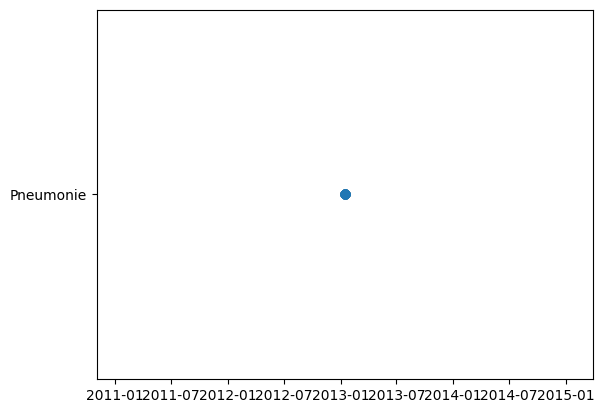

In [55]:
df3_sorted = df3.sort_values('condition_start_datetime', ascending=True)
plt.scatter(df3_sorted['condition_start_datetime'],df3_sorted['condition_source_value'])


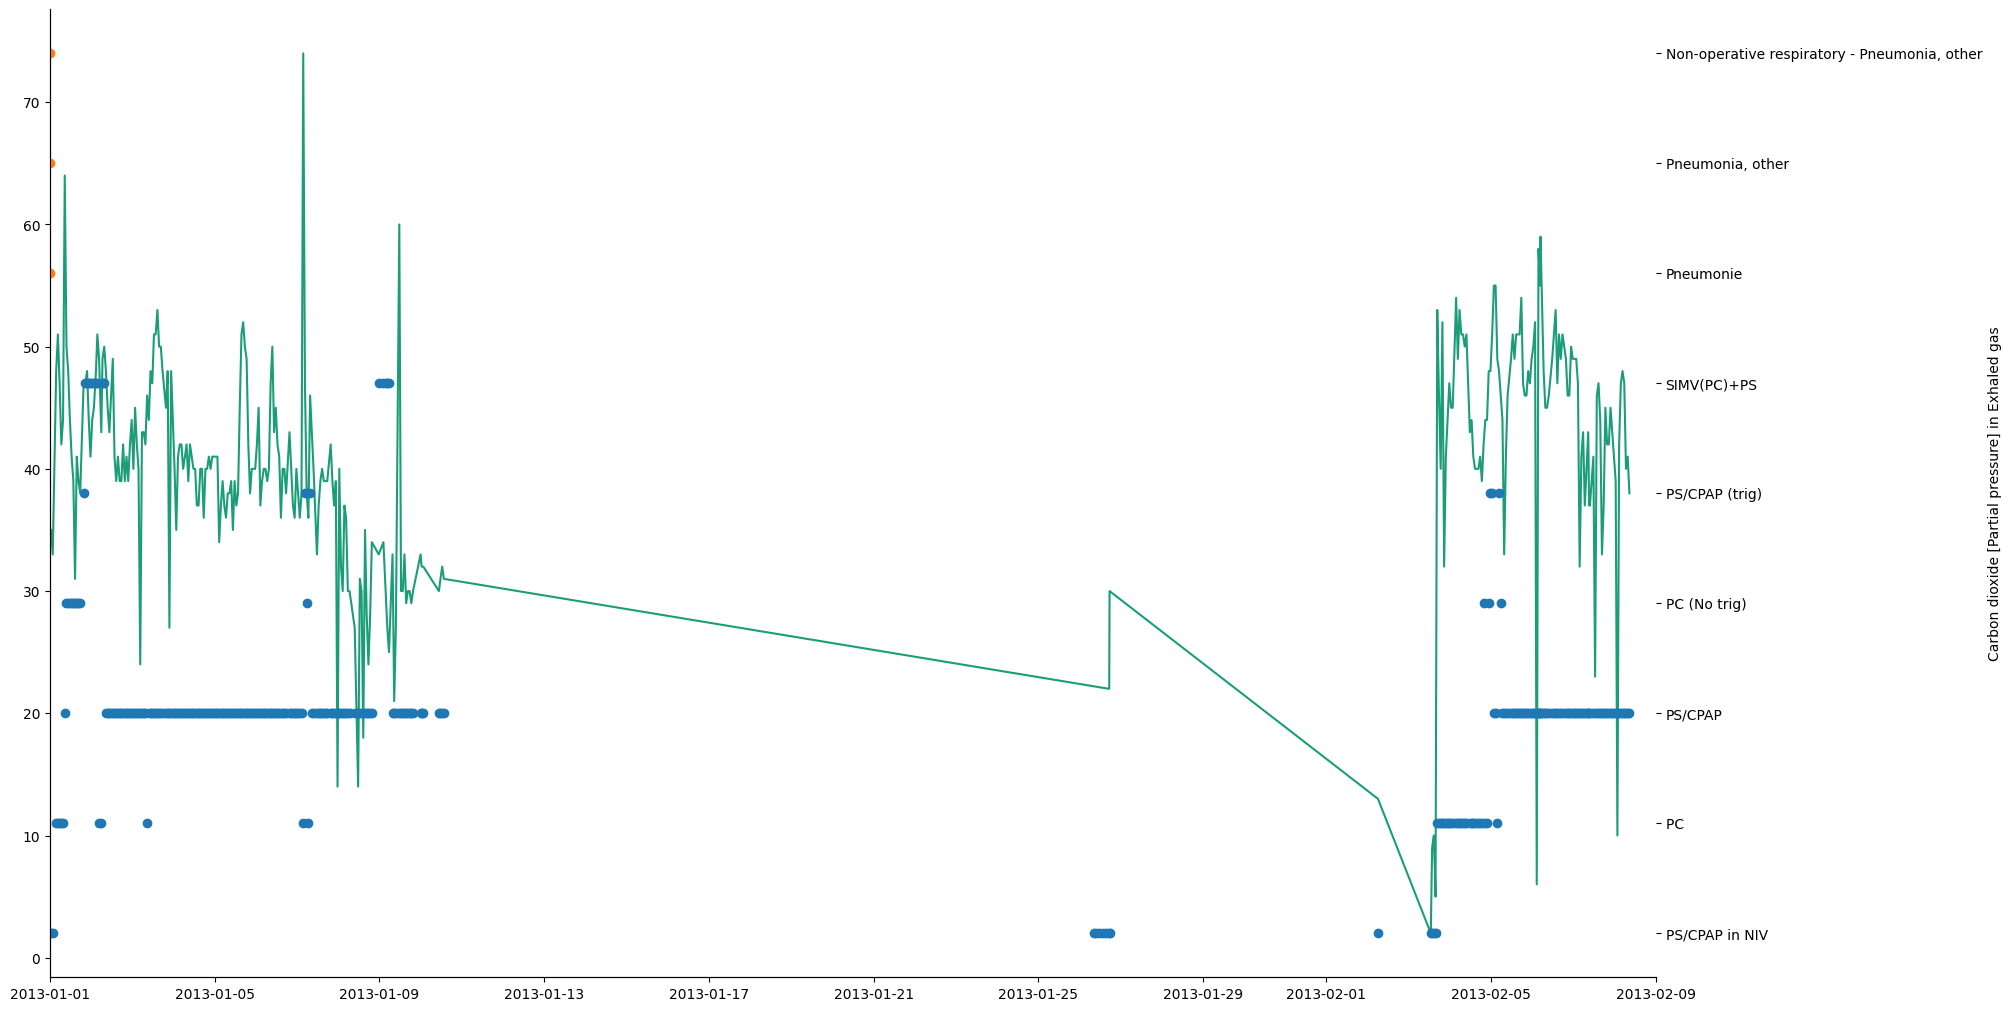

In [80]:
#set params
#figure(figsize=(width, height)) function,
#fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

fig, ax = plt.subplots(figsize=(20, 10), layout='constrained')
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 2, 9)])

#sort cO2PP and pass to _plot_series function
df_sorted = cO2PP.sort_values('measurement_datetime', ascending=True)
_plot_series(df_sorted, '', 'value_as_number')

#sort cO2PP and pass to _plot_series function
df2_sorted = ventPP.sort_values('measurement_datetime', ascending=True)
#_plot_series(df2_sorted, '', 'value_source_value')

#introduce ax2
ax2 = ax.twinx()
plt.scatter(df2_sorted['measurement_datetime'],df2_sorted['value_source_value'])

df3_sorted = df3.sort_values('condition_start_datetime', ascending=True)
plt.scatter(df3_sorted['condition_start_datetime'],df3_sorted['condition_source_value'])

# x = xs (measurement_datetime)
# y = (similar to above - series pass via  _plot_series (df_sorted))
#ax2.plot(t, data2, color = color)

sns.despine(fig=fig, ax=ax) #extends plot based on figsize values above
plt.xlabel('measurement_datetime')
_ = plt.ylabel('Carbon dioxide [Partial pressure] in Exhaled gas')

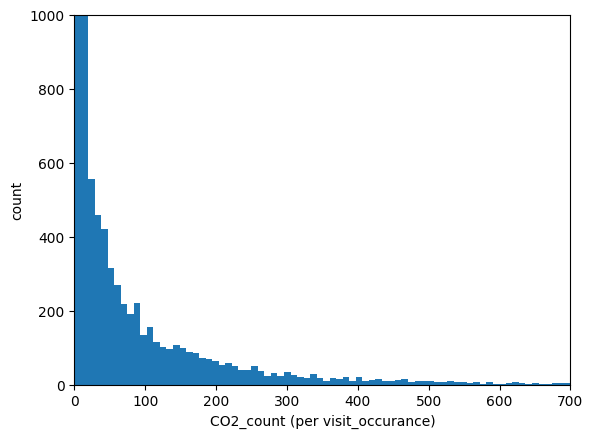

In [ ]:
# @title f0_
#cO2PP_test['f0_'].plot(kind='line', figsize=(8, 4), title='f0_')
#plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
limit1, limit2 = 10, 550
binwidth1 = 10

#data_ag = cO2PP_test.groupby('visit_occurrence_CO2_count')['visit_occurrence_CO2_count'].count()
#data_ag = cO2PP_test.groupby(pd.cut(cO2PP_test['visit_occurrence_CO2_count'], [0, 10, 20, 30, 40, 50, 60])).sum()
#data_ag = cO2PP_test.groupby(pd.cut(cO2PP_test['visit_occurrence_CO2_count'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])).count
#print(dataAgg)

plt.hist(cO2PP_test, bins=350)
#plt.hist(cO2PP_test, bins=[140, 150, 160, 175, 185, 200])

plt.xlim(0, 700)
plt.ylim(0, 1000)
# Set title
# adding labels
plt.xlabel('CO2_count (per visit_occurance)')
plt.ylabel('count')

#plt.gca().invert_yaxis() - just turns it around
plt.show()

#df = pd.DataFrame({"a": cO2PP_test}, index=[0])
#df.groupby('a').value_counts()
#df['a'].value_counts(bins=10, sort=False)
#pd.value_counts(cO2PP_test, bins=10)
#data['title'].value_counts()[:20].plot(kind='barh')



Maybe look into the relationship between the above CO2 and ventilator settings TV volumes

Expired MV
Could I also look at 42527120	Expired minute Volume during Mechanical ventilation	Measurement	Clinical Observation	LOINC	76008-2	AUMC Numeric	16244	Zephyros Mve
